# Chapter 4 - Training Linear Models: Linear Regression and Gradient Descent

Notes: We can represent any set of data points, examples with feature vectors x and labels y, as a matrix X of all the feature vectors and a vector y of the labels for each example. We can choose to model this a linear equation: X * theta = y. (In linalg 101 this is Ax=b.) Theta is a vector of coefficient for this linear equation. For example a single row would look like: x_1 * theta_1 + x_2 * theta_2 + ... + x_n * theta_n + 1 * theta_0 = y^1.

Because any set of points will not perfectly follow a line or curve, there is not an exact vector theta that when multiplied by X will result in y. (In linalg 101 we say "y is not in the column space of X".) We could check that by using traditional linalg solving (Gaussian Elimination) and find that the system has no solutions (0 /= 1 kind of thing). In linear algebra we showed that the closest approximation we can get to y when it is not in the column space X * theta (for any theta no matter what we choose) is a projection onto the hyperplane of X * theta for all possible thetas. (We might refer to this hyperplane as the subspace W that equals Ax. The subspace W is the column space of X.)

The particular theta that gives this projection when multiplied by X is found by solving the "Normal Equation": A^t * A * x = A^t * y. (Or in our case X^t * X * theta = X^t * y.) (I have a nice proof of why the Normal Equation is gives this projection in my linalg notes.)

So for any set of data points in machine learning, we can choose to model it as a linear function (a line or any polynomial curve) and it will have a closed form solution given by the Normal Equation, or we can choose to find the theta that minimizes the loss by gradient descent.

## Linear Regession by Least Squares

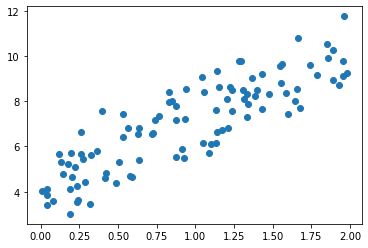

In [55]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(0)
X = 2 * np.random.rand(100, 1) # x values from 0-2
y = 4 + 3 * X + np.random.randn(100, 1)

plt.scatter(X, y)

In [56]:
# X with bias column
X_b = np.concatenate((np.ones((X.shape)), X), axis=1) # add x0 = 1 to each instance
# Solve normal equation. We expect to get close to (4, 3) as declared in the cell above for y 
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y 
theta_best

array([[4.22215108],
       [2.96846751]])

In [57]:
X_new = np.array([[0], [2]])
X_new_b = np.concatenate((np.ones(X_new.shape), X_new), axis=1)
y_predict = X_new_b @ theta_best
y_predict

array([[ 4.22215108],
       [10.1590861 ]])

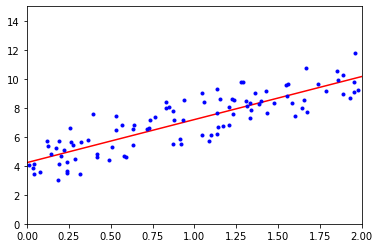

In [58]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [59]:
# Getting theta from sklearns linear regression learner
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
theta_best_sklearn = lin_reg.intercept_, lin_reg.coef_
theta_best_sklearn

(array([4.22215108]), array([[2.96846751]]))

In [60]:
lin_reg.predict(X_new)

array([[ 4.22215108],
       [10.1590861 ]])

In [61]:
# sklearn simply uses the np.linalg least squares function which is what we wrote by hand above.
theta_best_np, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_np


array([[4.22215108],
       [2.96846751]])

### Computational Complexity
1. Least squares by solving Normal Equation: 
    O(n^3) for n features, linear with number of examples
2. Least squares by doing pseudo-inverse of X with Singular Value Decomposition (what np and sklearn do):
    O(n^2) for n features, linear with number of examples

## Linear Regression by Gradient Descent

In [71]:
# Quick implementation of gradient descent algorithm
# Use MSE for Loss function: L = 1/m * sum_over_m((x^i * theta - y^i)**2)

# Hyperparameters
ETA = 0.1 # learning rate
SCHEDULE = 5 # Adaptive learning schedule rate (higher value means ETA decreases more slowly and the algorithm converges more agressively)
EPOCHS = 1000
BATCH_SIZE = 20

np.random.seed(0)

theta_path_bgd = []
theta_path_sgd = []
theta_path_mgd = []

# Partial derivative of Loss w.r.t. theta for single example (Stochastic Gradient Descent)
def dL_dtheta_single(theta, xi, yi):
    gradient = 2 * xi * (xi.dot(theta) - yi) 
    return gradient

# Partial derivative of Loss w.r.t. theta for all examples (Batch Gradient Descent)
def dL_dtheta(theta, X, y):
    m = len(X)
    gradient = 1/m * 2 * X.T @ (X @ theta - y)
    return gradient

def learning_schedule(t):
    # Notice SCHEDULE / (SCHEDULE / ETA) = ETA, t is added to decrease ETA by a factor moderated by the size of SCHEDULE
    learning_rate = SCHEDULE / (t + (SCHEDULE / ETA))
    return learning_rate

def gradient_descent(X, y):
    theta = np.random.randn(2,1) # random initialization
    for epoch in range(EPOCHS):
        gradient = dL_dtheta(theta, X, y)
        theta = theta - ETA * gradient
        theta_path_bgd.append(theta) # For plotting later
    return theta

def stochatistic_gradient_descent(X, y):
    theta = np.random.randn(2,1) # random initialization
    for epoch in range(EPOCHS):
        for j in range(len(X)):
            i = np.random.randint(len(X))
            gradient = dL_dtheta_single(theta, X[i], y[i])
            gradient = gradient.reshape(theta.shape)
            eta = learning_schedule(epoch * len(X) + j)
            theta = theta - eta * gradient
            theta_path_sgd.append(theta)  # For plotting later
    return theta

def minibatch_gradient_descent(X, y):
    theta = np.random.randn(2,1) # random initialization
    for epoch in range(EPOCHS):
        batches_per_epoch = len(X) // BATCH_SIZE
        for j in range(batches_per_epoch):
            i = np.random.randint(len(X) - BATCH_SIZE + 1)
            X_batch = X[i:i+BATCH_SIZE]
            y_batch = y[i:i+BATCH_SIZE]
            gradient = dL_dtheta(theta, X_batch, y_batch)
            eta = learning_schedule(epoch * batches_per_epoch + j)
            theta = theta - eta * gradient
            theta_path_mgd.append(theta)  # For plotting later
    return theta

# Notice the minibatch_gradient_descent is equivalent to either SGD or standard gradient descent if you
# set batch size to either 1 or to the full size of the dataset.
print(gradient_descent(X_b, y))
print(stochatistic_gradient_descent(X_b, y))
print(minibatch_gradient_descent(X_b, y))

[[4.22215108]
 [2.96846751]]
[[4.22370473]
 [2.96504868]]
[[4.22921218]
 [2.98121444]]


In [72]:
# Using sklearn:

from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=EPOCHS, tol=1e-3, penalty=None, eta0=ETA)
sgd_reg.fit(X, y.ravel())
theta_sgd_reg = sgd_reg.intercept_, sgd_reg.coef_
theta_sgd_reg

(array([4.24968609]), array([2.96924207]))

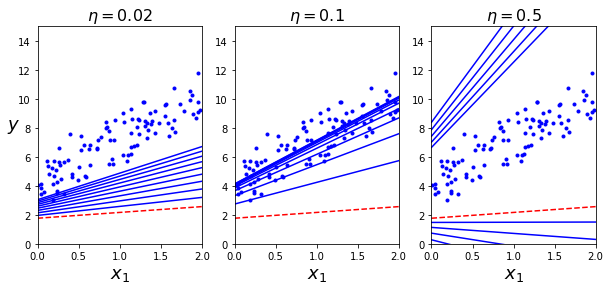

In [89]:
X_new = np.array([[0], [2]])
X_new_b = np.concatenate((np.ones(X_new.shape), X_new), axis=1)

def plot_gradient_descent(X, y, eta):
    np.random.seed(0)
    theta = np.random.randn(2,1)  # random initialization   
    plt.plot(X[:, 1], y, "b.")
    for iteration in range(10):
        y_predict = X_new_b.dot(theta)
        style = "b-" if iteration > 0 else "r--"
        plt.plot(X_new, y_predict, style)
        gradient = dL_dtheta(theta, X, y)
        theta = theta - eta * gradient
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(X_b, y, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(X_b, y, eta=0.1)
plt.subplot(133); plot_gradient_descent(X_b, y, eta=0.5)
plt.show()

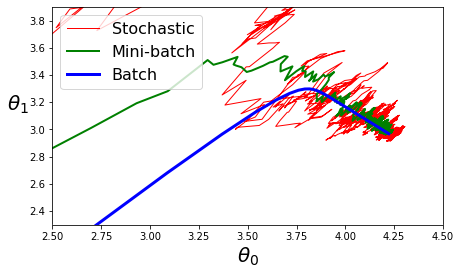

In [74]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## Linear regression of polynomial degree
(nonlinear, curved data)

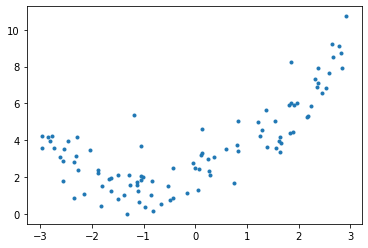

In [114]:
m = 100
X = -3 + 6 * np.random.rand(m, 1) # values from -3 to 6
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.plot(X, y, '.')

In [115]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
theta_poly = lin_reg.intercept_, lin_reg.coef_
theta_poly

(array([2.08461499]), array([[0.92553107, 0.51097283]]))

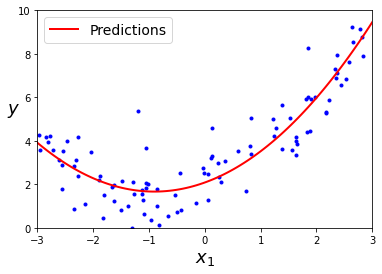

In [116]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

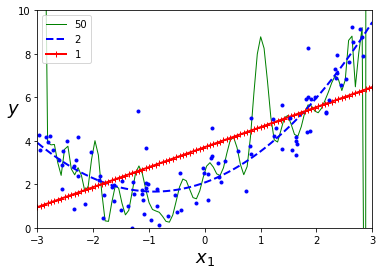

In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 50), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

## Regularization - Ridge, Lasso, and Elastic

In [90]:
# np.random.seed(42)
# m = 20
# X = 3 * np.random.rand(m, 1)
# y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
# X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [150]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1e-7, solver="cholesky")
ridge_reg.fit(X, y)
sgd_reg = SGDRegressor(penalty="l2", alpha=1e-7)
sgd_reg.fit(X, y.ravel())

print(ridge_reg.predict([[1.5]]))
print(sgd_reg.predict([[1.5]]))

[[5.09262837]]
[5.06174513]


In [151]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=1)
lasso_reg.fit(X, y)
sgd_reg = SGDRegressor(penalty="l1", alpha=1)
sgd_reg.fit(X, y.ravel())

print(lasso_reg.predict([[1.5]]))
print(sgd_reg.predict([[1.5]]))

[4.59765534]
[4.5503945]


In [155]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.0001, l1_ratio=0.15, random_state=42)
elastic_net.fit(X, y)
sgd_reg = SGDRegressor(penalty="elasticnet", alpha=0.0001, l1_ratio=0.15,)
sgd_reg.fit(X, y.ravel())

print(elastic_net.predict([[1.5]]))
print(sgd_reg.predict([[1.5]]))

[5.09258224]
[5.06108204]


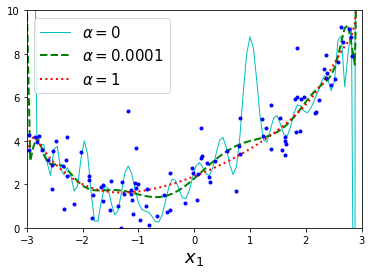

/home/monte/code/handson-ml2-monte/.venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e+01, tolerance: 5.496e-02
  model = cd_fast.enet_coordinate_descent(


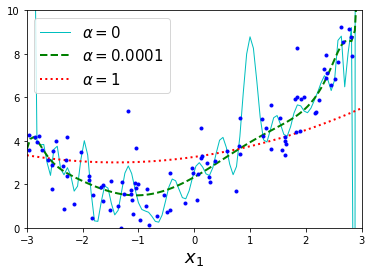

/home/monte/code/handson-ml2-monte/.venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.109e+01, tolerance: 5.496e-02
  model = cd_fast.enet_coordinate_descent(


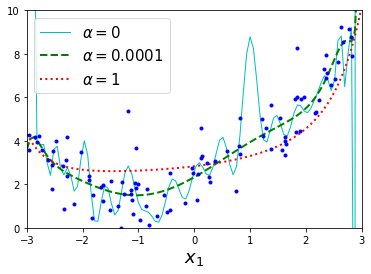

In [154]:


def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("c-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=50, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([-3, 3, 0, 10])

plot_model(Ridge, polynomial=True, alphas=(0, 1e-4, 1), random_state=42)
plt.show()

plot_model(Lasso, polynomial=True, alphas=(0, 1e-4, 1), random_state=42)
plt.show()

plot_model(ElasticNet, polynomial=True, alphas=(0, 1e-4, 1), random_state=42, l1_ratio=0.15)
plt.show()